# **Лабораторная работа 9.1 Титаник ML**

1.Загрузить файл, разделить его на train и test. Для test взять 10% случайно выбранных строк таблицы.

2.Обучить модели: Decision Tree, XGBoost, Logistic Regression из библиотек sklearn и xgboost. Обучить модели предсказывать столбец label по остальным столбцам таблицы.

3.Наладить замер Accuracy - доли верно угаданных ответов.
Точности всех моделей не должны быть ниже 85%

4.С помощью Decision Tree выбрать 2 самых важных признака и проверить точность модели, обученной только на них. 

In [ ]:
!pip install scikit-learn==1.2.1


In [267]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [268]:
df_titanic = pd.read_csv("/content/titanic_prepared.csv")
df_titanic

,Unnamed: 0,sex,row_number,liters_drunk,drink,check_number,label,age_child,age_adult,age_old,morning,day,evening
0,0,0,90.0,1.0,1,8092,1,False,False,True,False,False,True
1,1,0,81.0,4.0,1,4252,1,False,True,False,False,True,False
2,2,1,14.0,3.0,0,6913,1,False,False,True,False,False,True
3,3,1,0.0,1.0,0,8479,1,False,False,True,False,True,False
4,4,1,84.0,1.0,0,6279,0,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6629,6629,1,55.0,2.0,0,1526,1,False,False,True,False,False,True
6630,6630,1,75.0,5.0,1,6690,0,False,False,True,False,True,False
6631,6631,1,1.0,2.0,1,2834,0,False,True,False,True,False,False
6632,6632,1,68.0,4.0,0,5126,1,False,True,False,False,True,False


In [269]:
def scale_data(X):
    scaler = MinMaxScaler()
    return scaler.fit_transform(X)

In [270]:
df_titanic = df_titanic.astype(int)
df_titanic = df_titanic.drop(['Unnamed: 0','row_number','check_number'], axis=1)
df_titanic

,sex,liters_drunk,drink,label,age_child,age_adult,age_old,morning,day,evening
0,0,1,1,1,0,0,1,0,0,1
1,0,4,1,1,0,1,0,0,1,0
2,1,3,0,1,0,0,1,0,0,1
3,1,1,0,1,0,0,1,0,1,0
4,1,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
6629,1,2,0,1,0,0,1,0,0,1
6630,1,5,1,0,0,0,1,0,1,0
6631,1,2,1,0,0,1,0,1,0,0
6632,1,4,0,1,0,1,0,0,1,0


In [271]:
def separation(df):
  train, validate, test = np.split(df.sample(frac=1, random_state=10),
                                 [int(.8 * len(df)), int(.9 * len(df))])
  return train,validate,test

In [272]:
X = df_titanic.drop(['label'], axis=1)
Y = df_titanic['label']


In [273]:
train_x,validate_x,test_x = separation(X)
train_y,validate_y,test_y = separation(Y)

train_x = scale_data(train_x)
validate_x = scale_data(validate_x)
test_x = scale_data(test_x)

In [274]:
def get_accuracy(model, xtest, ytest):
    predict = model.predict(xtest)
    return accuracy_score(ytest, predict)

# Decision Tree

In [275]:
def dt(xtrain,ytrain,xvalidate,yvalidate):
  cls = DecisionTreeClassifier()
  param = {
      'criterion':['gini', 'entropy', 'log_loss'],
      'max_depth': range(1,50,1),
      
          }
  grid = GridSearchCV(cls, param)
  grid.fit(xtrain,ytrain)
  criterion = grid.best_params_.get('criterion')
  max_depth = grid.best_params_.get('max_depth')
  model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)
  model.fit(xtrain,ytrain)
  predict = model.predict(xvalidate)
  # print(predict)
  acc = accuracy_score(yvalidate,predict)
  print(f'Лучшие параметры:\n{grid.best_params_}')
  print('Лучшая accuracy на валидации: {:.2%}'.format(acc))
  return model



In [276]:
model_DT = dt(train_x,train_y,validate_x,validate_y)
acc = get_accuracy(model_DT,test_x,test_y)
print('Accuracy на тесте: {:.2%}'.format(acc))

Лучшие параметры:
{'criterion': 'entropy', 'max_depth': 6}
Лучшая accuracy на валидации: 90.50%
Accuracy на тесте: 90.06%


# XGBoost

In [277]:
def XGB(xtrain,ytrain,xvalidate,yvalidate):
  cls = XGBClassifier()
  param = {
       'max_depth': range(2, 10, 1),
       'n_estimators': range(50,150 , 10),
       'learning_rate': [0.1, 0.01, 0.05]
      
          }
  grid = GridSearchCV(cls, param)
  grid.fit(xtrain,ytrain)
  n_estimators = grid.best_params_.get('n_estimators')
  max_depth = grid.best_params_.get('max_depth')
  learning_rate = grid.best_params_.get('learning_rate')
  model = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators)
  model.fit(xtrain,ytrain)
  predict = model.predict(xvalidate)
  # print(predict)
  acc = accuracy_score(yvalidate,predict)
  print(f'Лучшие параметры:\n{grid.best_params_}')
  print('Лучшая accuracy на валидации: {:.2%}'.format(acc))
  return model

In [278]:
model = XGB(train_x,train_y,validate_x,validate_y)
acc = get_accuracy(model,test_x,test_y)
print('Accuracy на тесте: {:.2%}'.format(acc))

Лучшие параметры:
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
Лучшая accuracy на валидации: 90.50%
Accuracy на тесте: 90.06%


# Logistic Regression

In [279]:
def LR(xtrain,ytrain,xvalidate,yvalidate):
  cls = LogisticRegression()
  param = {
       'C': np.arange(0.01, 1, 0.01),
       'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
      
          }
  grid = GridSearchCV(cls, param)
  grid.fit(xtrain,ytrain)
  C = grid.best_params_.get('C')
  solver = grid.best_params_.get('solver')
  model = LogisticRegression(C=C, solver=solver)
  model.fit(xtrain,ytrain)
  predict = model.predict(xvalidate)
  # print(predict)
  acc = accuracy_score(yvalidate,predict)
  print(f'Лучшие параметры:\n{grid.best_params_}')
  print('Лучшая accuracy на валидации: {:.2%}'.format(acc))
  return model

In [280]:
model = LR(train_x,train_y,validate_x,validate_y)
acc = get_accuracy(model,test_x,test_y)
print('Accuracy на тесте: {:.2%}'.format(acc))

Лучшие параметры:
{'C': 0.01, 'solver': 'lbfgs'}
Лучшая accuracy на валидации: 87.48%
Accuracy на тесте: 87.20%


# Decision Tree 2 важных признака

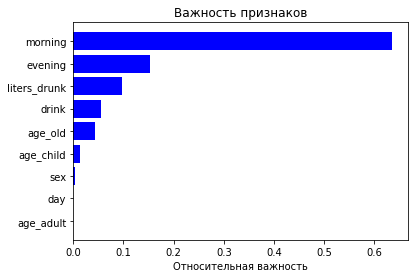

In [281]:
importances = model_DT.feature_importances_
features = X.columns
# Добавление сортировки по важности
indices = np.argsort(importances)
plt.title('Важность признаков')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Относительная важность')
plt.show()

In [282]:
n = 2
important_2 = X[features[indices][-n:]]

train_x,validate_x,test_x = separation(important_2)
train_x = scale_data(train_x)
validate_x = scale_data(validate_x)
test_x = scale_data(test_x)
model_DT.fit(train_x,train_y)
acc = get_accuracy(model_DT,test_x,test_y)
print('Accuracy: {:.2%}'.format(acc))
# important_2

Accuracy: 87.20%
